In [534]:
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [535]:
# convert series to supervised learning
def series_to_supervised(data, n_in=6, n_out=12, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [536]:
#load daraset
dataset= read_csv('powerandweather.csv', header=0, index_col='time')



In [537]:
#dataset.tail(20)

In [538]:
dataset.replace([np.inf ,-np.inf],np.nan)
dataset.fillna(method='ffill')
values=dataset.values

In [539]:
# normalize features
data=dataset
data['cloudCover'] = (data['cloudCover']- data['cloudCover'].min())/(data['cloudCover'].max()-data['cloudCover'].min())
data['dewPoint'] = (data['dewPoint']-data['dewPoint'].min())/(data['dewPoint'].max()-data['dewPoint'].min())
data['humidity'] = (data['humidity']-data['humidity'].min())/(data['humidity'].max()-data['humidity'].min())
data['temperature'] = (data['temperature']-data['temperature'].min())/(data['temperature'].max()-data['temperature'].min())
data['pressure'] = (data['pressure']-data['pressure'].min())/(data['pressure'].max()-data['pressure'].min())
data['windBearing'] = (data['windBearing']-data['windBearing'].min())/(data['windBearing'].max()-data['windBearing'].min())
data['windSpeed'] = (data['windSpeed']-data['windSpeed'].min())/(data['windSpeed'].max()-data['windSpeed'].min())
#data['power'] = (data['power']-data['power'].min())/(data['power'].max()-data['power'].min())
data['power']=data['power']/50000

scaled=data


In [541]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [542]:
reframed.head(10)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
time,,,,,,,,,,,,,,,,
1521061500,0.38,0.570005,0.769231,0.268186,0.521311,0.662953,0.170129,0.0,0.38,0.568983,0.769231,0.289517,0.518033,0.660167,0.167883,0.0
1521061800,0.38,0.568983,0.769231,0.289517,0.518033,0.660167,0.167883,0.0,0.39,0.567961,0.769231,0.288970,0.518033,0.657382,0.165637,0.0
1521062100,0.39,0.567961,0.769231,0.288970,0.518033,0.657382,0.165637,0.0,0.39,0.566939,0.769231,0.288423,0.518033,0.651811,0.163391,0.0
1521062400,0.39,0.566939,0.769231,0.288423,0.518033,0.651811,0.163391,0.0,0.40,0.565917,0.769231,0.288058,0.518033,0.649025,0.161145,0.0
1521062700,0.40,0.565917,0.769231,0.288058,0.518033,0.649025,0.161145,0.0,0.40,0.564895,0.769231,0.287511,0.518033,0.646240,0.159461,0.0
1521063000,0.40,0.564895,0.769231,0.287511,0.518033,0.646240,0.159461,0.0,0.41,0.563873,0.769231,0.287147,0.518033,0.643454,0.157215,0.0
1521063300,0.41,0.563873,0.769231,0.287147,0.518033,0.643454,0.157215,0.0,0.41,0.562851,0.769231,0.286600,0.518033,0.637883,0.155531,0.0
1521063600,0.41,0.562851,0.769231,0.286600,0.518033,0.637883,0.155531,0.0,0.42,0.561829,0.769231,0.286053,0.518033,0.635097,0.153846,0.0
1521063900,0.42,0.561829,0.769231,0.286053,0.518033,0.635097,0.153846,0.0,0.42,0.560807,0.769231,0.285688,0.514754,0.629526,0.152162,0.0


In [517]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13,14]], axis=1, inplace=True)

In [518]:
#print(reframed.head(20))

In [519]:
reframed.columns


Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var8(t)'],
      dtype='object')

In [520]:
len_data=len(reframed);
train_len= int(len_data*0.8);

# split into train and test sets
values = reframed.values
train = values[:train_len, :]
test = values[train_len:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)




(14378, 1, 8) (14378,) (3595, 1, 8) (3595,)


Train on 14378 samples, validate on 3595 samples
Epoch 1/50
 - 2s - loss: 0.1065 - acc: 0.4640 - val_loss: 0.0917 - val_acc: 0.4047
Epoch 2/50
 - 0s - loss: 0.0321 - acc: 0.4640 - val_loss: 0.0334 - val_acc: 0.4047
Epoch 3/50
 - 0s - loss: 0.0208 - acc: 0.4640 - val_loss: 0.0344 - val_acc: 0.4047
Epoch 4/50
 - 0s - loss: 0.0203 - acc: 0.4640 - val_loss: 0.0323 - val_acc: 0.4047
Epoch 5/50
 - 0s - loss: 0.0201 - acc: 0.4640 - val_loss: 0.0324 - val_acc: 0.4047
Epoch 6/50
 - 0s - loss: 0.0199 - acc: 0.4640 - val_loss: 0.0326 - val_acc: 0.4047
Epoch 7/50
 - 0s - loss: 0.0197 - acc: 0.4640 - val_loss: 0.0327 - val_acc: 0.4047
Epoch 8/50
 - 0s - loss: 0.0197 - acc: 0.4640 - val_loss: 0.0360 - val_acc: 0.4047
Epoch 9/50
 - 0s - loss: 0.0194 - acc: 0.4640 - val_loss: 0.0336 - val_acc: 0.4047
Epoch 10/50
 - 0s - loss: 0.0194 - acc: 0.4640 - val_loss: 0.0347 - val_acc: 0.4047
Epoch 11/50
 - 0s - loss: 0.0193 - acc: 0.4640 - val_loss: 0.0371 - val_acc: 0.4047
Epoch 12/50
 - 0s - loss: 0.0191 - a

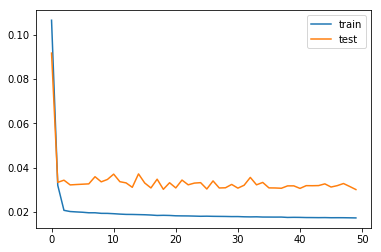

In [521]:
# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', metrics=['accuracy'],optimizer='rmsprop')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=True)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [522]:
yhat = model.predict(test_X)

In [523]:
yhat.shape

(3595, 1)

In [524]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

test_y = test_y.reshape((len(test_y), 1))

# calculate RMSE
rmse = sqrt(mean_squared_error(yhat[0:len(yhat)-2,0],test_y[1:len(test_y)-1,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.103


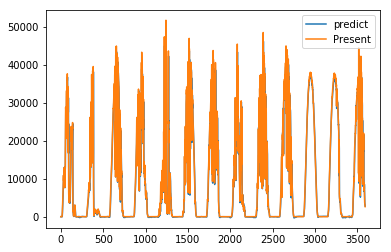

In [527]:
pyplot.plot(yhat[0:len(yhat)-2,0]*50000, label= 'predict')
pyplot.plot(test_y[1:len(test_y)-1,0]*50000, label= 'Present')
pyplot.legend()
pyplot.show()


In [528]:
import pandas as pd
df= pd.DataFrame(yhat)
df.to_csv("yhat.csv",index=False)
df= pd.DataFrame(test_y)
df.to_csv("test.csv",index=False)


In [530]:
test_X[0]

array([0.44      , 0.91415432, 0.76923077, 0.54475843, 0.41967213,
       0.33983287, 0.17405952, 0.        ])

In [533]:
df= pd.DataFrame(test_X[:,0])
df.to_csv('cloudcover.csv', index=False)

In [532]:
test_X.shape

(3595, 8)